# Structured State Spaces (S4) model training on the Light-HAR dataset

## Setting Up the Notebook

In [1]:
# Install the S4 package if you haven't already
# %%capture
# ! git clone https://github.com/state-spaces/s4.git
# ! cd s4 && pip install -r requirements.txt

In [2]:
# Mount Google Drive if using Colab
# from google.colab import drive
# drive.mount('/content/drive')
# project_path = '/content/drive/MyDrive/AI/CGD_research/light-har'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.backends.cudnn as cudnn
from torch.utils.data import TensorDataset, DataLoader
import torch.nn.functional as F

import os
import argparse

# Import the s4 model path
import sys
sys.path.append('C:/Users/poomc/Development/s4')

from models.s4.s4 import S4Block as S4
from models.s4.s4d import S4D
from tqdm.auto import tqdm

from numpy import genfromtxt
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

import matplotlib.pyplot as plt
import psutil
import time
from pathlib import Path


CUDA extension for structured kernels (Cauchy and Vandermonde multiplication) not found. Install by going to extensions/kernels/ and running `python setup.py install`, for improved speed and memory efficiency. Note that the kernel changed for state-spaces 4.0 and must be recompiled.
Falling back on slow Cauchy and Vandermonde kernel. Install at least one of pykeops or the CUDA extension for better speed and memory efficiency.


In [2]:
# Torch device configuration
device = (
    "cuda" if torch.cuda.is_available() else "mps"
    if torch.backends.mps.is_available() else "cpu"
)
print(f"Using {device} device")
if torch.cuda.is_available():
    print(f"Current GPU device: {torch.cuda.get_device_name(device)}")

Using cuda device
Current GPU device: NVIDIA GeForce RTX 3080


## Importing the Dataset

In [3]:
project_path = "C:/Users/poomc/Development/light-har"

# Load Data
x = genfromtxt(project_path+'/data/WISDM_x.csv', delimiter=',')
y_df = pd.read_csv(project_path+'/data/WISDM_y.csv')
y = y_df.values.flatten()  # Flatten if y is 2D

# Encode labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Function to create time series dataset
def create_series(x, y, timestep, overlap):
    slide_step = int(timestep * (1 - overlap))
    data_num = int((len(x) / slide_step) - 1)
    dataset = np.ndarray(shape=(data_num, timestep, x.shape[1]))
    labels = []

    for i in range(data_num):
        labels.append(y[slide_step * (i + 1) - 1])
        for j in range(timestep):
            dataset[i, j, :] = x[slide_step * i + j, :]

    return dataset, np.array(labels)

In [4]:
# Create time series
seq_length = 16
overlap = 0.5
X_series, y_series = create_series(x, y_encoded, seq_length, overlap)

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X_series, y_series, test_size=0.2, random_state=42)

# Convert to PyTorch tensors
x_train_tensor = torch.tensor(X_train, dtype=torch.float32)
x_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

print(x_train_tensor.shape)
print(y_train_tensor.shape)

torch.Size([104856, 16, 3])
torch.Size([104856])


In [5]:
# Create a DataLoader
batch_size = 32
train_dataset = TensorDataset(x_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=False)

# Create a test Dataloader
test_dataset = TensorDataset(x_test_tensor, y_test_tensor)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=True)

## Constructing the Model

In [6]:
class S4Model(nn.Module):
    def __init__(
        self,
        d_input,
        d_output,
        d_model=256,
        n_layers=4,
        dropout=0.2,
        lr=0.001,
        dropout_fn=nn.Dropout,
        prenorm=False,
    ):
        super().__init__()

        self.prenorm = prenorm

        # Linear encoder (d_input = 1 for grayscale and 3 for RGB)
        self.encoder = nn.Linear(d_input, d_model)

        # Stack S4 layers as residual blocks
        self.s4_layers = nn.ModuleList()
        self.norms = nn.ModuleList()
        self.dropouts = nn.ModuleList()
        for _ in range(n_layers):
            self.s4_layers.append(
                S4D(d_model, dropout=dropout, transposed=True, lr=lr)
            )
            self.norms.append(nn.LayerNorm(d_model))
            self.dropouts.append(dropout_fn(dropout))

        # Linear decoder
        self.decoder = nn.Linear(d_model, d_output)

    def forward(self, x):
        """
        Input x is shape (B, L, d_input)
        """
        x = self.encoder(x)  # (B, L, d_input) -> (B, L, d_model)

        x = x.transpose(-1, -2)  # (B, L, d_model) -> (B, d_model, L)
        for layer, norm, dropout in zip(self.s4_layers, self.norms, self.dropouts):
            # Each iteration of this loop will map (B, d_model, L) -> (B, d_model, L)

            z = x
            if self.prenorm:
                # Prenorm
                z = norm(z.transpose(-1, -2)).transpose(-1, -2)

            # Apply S4 block: we ignore the state input and output
            z, _ = layer(z)

            # Dropout on the output of the S4 block
            z = dropout(z)

            # Residual connection
            x = z + x

            if not self.prenorm:
                # Postnorm
                x = norm(x.transpose(-1, -2)).transpose(-1, -2)

        x = x.transpose(-1, -2)

        # Pooling: average pooling over the sequence length
        x = x.mean(dim=1)

        # Decode the outputs
        x = self.decoder(x)  # (B, d_model) -> (B, d_output)

        return x


In [17]:
model = S4Model(
    d_input=3, # num of feature
    d_output=6, # 6 classes
    d_model=16,
    n_layers=4,
    dropout=0.2,
    lr=0.001,
    dropout_fn=nn.Dropout,
    prenorm=False,
)
model.eval()

S4Model(
  (encoder): Linear(in_features=3, out_features=16, bias=True)
  (s4_layers): ModuleList(
    (0-3): 4 x S4D(
      (kernel): S4DKernel()
      (activation): GELU(approximate='none')
      (dropout): DropoutNd()
      (output_linear): Sequential(
        (0): Conv1d(16, 32, kernel_size=(1,), stride=(1,))
        (1): GLU(dim=-2)
      )
    )
  )
  (norms): ModuleList(
    (0-3): 4 x LayerNorm((16,), eps=1e-05, elementwise_affine=True)
  )
  (dropouts): ModuleList(
    (0-3): 4 x Dropout(p=0.2, inplace=False)
  )
  (decoder): Linear(in_features=16, out_features=6, bias=True)
)

## Training

In [7]:
# Validate the model given the dataloader and return loss and accuracy
def validate(model, dataloader, device):
    model.eval()
    criterion = nn.CrossEntropyLoss()
    running_loss = 0.0
    true_labels = []
    predicted_labels = []

    with torch.no_grad():
        for X_batch, y_batch in dataloader:
            inputs, labels = X_batch.to(device), y_batch.to(device)
            output = model(inputs)
            loss = criterion(output, labels)
            running_loss += loss.item()

            _, predicted = torch.max(output.data, 1)
            true_labels.extend(labels.cpu().numpy())
            predicted_labels.extend(predicted.cpu().numpy())

    avg_loss = running_loss / len(dataloader)
    accuracy = accuracy_score(true_labels, predicted_labels) * 100

    return avg_loss, accuracy

# Plot training history and save figures
def plot_metrics(num_epochs, train_losses, val_losses, val_accuracies, save_path=None):
    epochs = range(1, num_epochs + 1)
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

    ax1.plot(epochs, train_losses, label='Training Loss', marker='o', color='blue')
    ax1.plot(epochs, val_losses, label='Validation Loss', marker='o', color='red')
    ax1.set_title('Training and Validation Losses')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Loss')
    ax1.legend()
    ax1.grid(True)

    ax2.plot(epochs, val_accuracies, label='Validation Accuracy', marker='o', color='green')
    ax2.set_title('Validation Accuracy')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Accuracy')
    ax2.legend()
    ax2.grid(True)

    plt.tight_layout()

    if save_path:
        plt.savefig(save_path)
    else:
        plt.show()


In [18]:
model.to(device)
loss, accuracy = validate(model, test_loader, device)
print(f"Untrained model accuracy = {accuracy:.2f} %")

Untrained model accuracy = 4.61 %


In [19]:
import torch
from torch.nn import CrossEntropyLoss

# Define the optimizer and loss function
optimizer = torch.optim.Adam(model.parameters())

loss_fn = CrossEntropyLoss()

num_epochs = 100
best_val_accuracy = 0.0  # Variable to track the best validation accuracy
best_model_state = None  # Variable to store the state of the best model

train_losses = []  # List to store training losses
val_losses = []    # List to store validation losses
val_accuracies = []  # List to store validation accuracies

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for X_batch, y_batch in train_loader:
        # Move inputs and labels to the selected device
        inputs, labels = X_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        output = model(inputs)
        loss = loss_fn(output, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    avg_loss = running_loss / len(train_loader)
    train_losses.append(avg_loss)

    # Validation loss calculation
    val_loss, val_acc = validate(model, test_loader, device)
    val_accuracies.append(val_acc)
    val_losses.append(val_loss)

    # Save the model if the current validation accuracy is better than the best
    if val_acc > best_val_accuracy:
        best_val_accuracy = val_acc
        best_model_state = model.state_dict()

    print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {avg_loss:.4f}, Val Accuracy: {val_acc:.2f}%")

print('Finished Training')
model.load_state_dict(best_model_state)
print('Best model state restored')

# Save the best model
model_path = project_path+'/models/s4_d16.pt'
torch.save(model.state_dict(), model_path)
print(f'Best model saved at {model_path}')

Epoch [1/100], Train Loss: 0.7214, Val Accuracy: 81.77%
Epoch [2/100], Train Loss: 0.5362, Val Accuracy: 83.26%
Epoch [3/100], Train Loss: 0.4886, Val Accuracy: 84.83%
Epoch [4/100], Train Loss: 0.4587, Val Accuracy: 86.02%
Epoch [5/100], Train Loss: 0.4348, Val Accuracy: 86.74%
Epoch [6/100], Train Loss: 0.4168, Val Accuracy: 87.43%
Epoch [7/100], Train Loss: 0.4015, Val Accuracy: 87.49%
Epoch [8/100], Train Loss: 0.3882, Val Accuracy: 88.32%
Epoch [9/100], Train Loss: 0.3795, Val Accuracy: 89.18%
Epoch [10/100], Train Loss: 0.3706, Val Accuracy: 89.86%
Epoch [11/100], Train Loss: 0.3635, Val Accuracy: 90.07%
Epoch [12/100], Train Loss: 0.3565, Val Accuracy: 90.18%
Epoch [13/100], Train Loss: 0.3526, Val Accuracy: 90.37%
Epoch [14/100], Train Loss: 0.3478, Val Accuracy: 90.51%
Epoch [15/100], Train Loss: 0.3437, Val Accuracy: 90.90%
Epoch [16/100], Train Loss: 0.3396, Val Accuracy: 91.08%
Epoch [17/100], Train Loss: 0.3357, Val Accuracy: 90.64%
Epoch [18/100], Train Loss: 0.3337, Val 

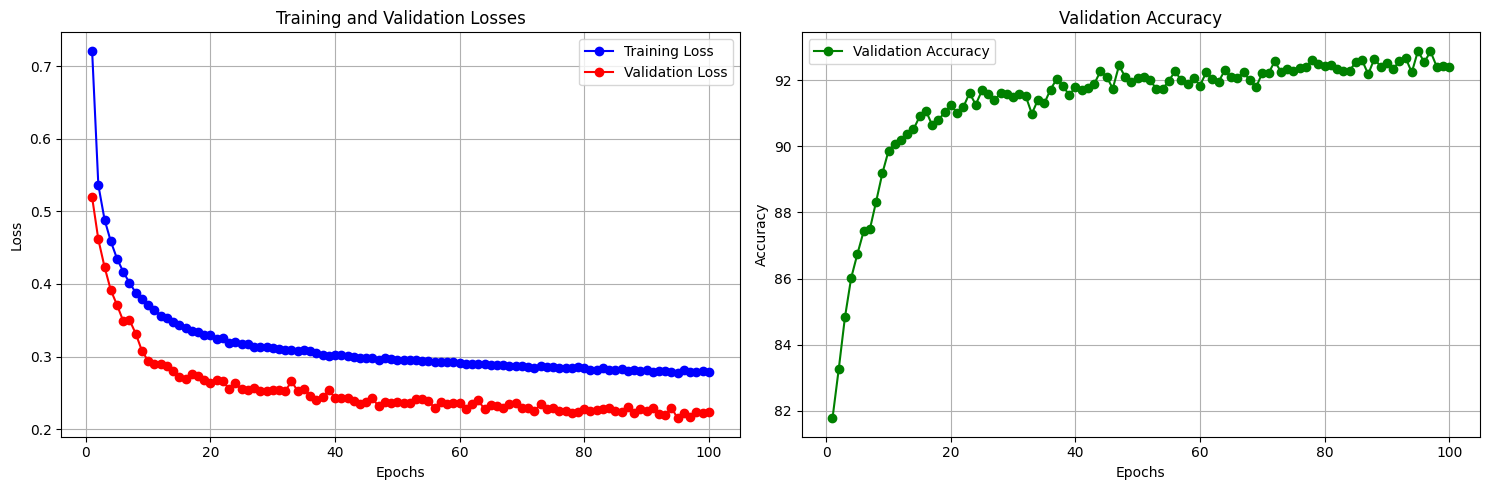

In [20]:
# Plot and save figures
plot_metrics(num_epochs,
             train_losses,
             val_losses,
             val_accuracies,
             save_path=project_path+'/models/s4-d16.png')

## Evaluating the model

In [8]:
def compute_metrics_base(model, dataloader, model_path):
    """
    Compute the accuracy of the PyTorch model.

    :param model: PyTorch model.
    :param dataloader: PyTorch's test dataloader.
    :param model_dir: Directory where the PyTorch model files are stored.
    :return: None
    """
    model.eval()
    with torch.no_grad():
        # Get the model's predictions
        val_loss, val_acc = validate(model, dataloader, 'cpu')

    model_file = Path(model_path)

    # Size in bytes
    model_size_bytes = model_file.stat().st_size
    model_size_kb = model_size_bytes / 1024
    print(f"Size of the model: {model_size_kb:.2f} KB")
    print(f"Accuracy on the test set: {val_acc:.2f} %")

def measure_cpu_utilization_and_run(func, *args, **kwargs):
    """
    Measure CPU utilization while running a function.

    Parameters:
        func (function): The function to be executed.
        *args: Arguments to be passed to func.
        **kwargs: Keyword arguments to be passed to func.

    Returns:
        float: CPU utilization percentage during the execution of func.
        float: The elapsed time during the execution of func.
        any: The result of func execution.
    """

    # Measure CPU utilization before execution
    cpu_percent_before = psutil.cpu_percent(interval=None)

    # Record the start time
    start_time = time.time()

    # Execute the function and store its result
    result = func(*args, **kwargs)

    # Record the end time
    end_time = time.time()

    # Measure CPU utilization after execution
    cpu_percent_after = psutil.cpu_percent(interval=None)

    # Calculate elapsed time and average CPU utilization
    elapsed_time = end_time - start_time
    average_cpu_utilization = (cpu_percent_before + cpu_percent_after) / 2

    return average_cpu_utilization, elapsed_time, result

In [13]:
model_path = project_path+'/code/s4/models/s4-d16.pt'

model = S4Model(
    d_input=3, # num of feature
    d_output=6, # 6 classes
    d_model=16,
    n_layers=4,
    dropout=0.2,
    lr=0.001,
    dropout_fn=nn.Dropout,
    prenorm=False,
)

model.eval()
model.load_state_dict(torch.load(model_path))

<All keys matched successfully>

In [14]:
model.to('cpu')
cpu_usage, inference_time, _ = measure_cpu_utilization_and_run(compute_metrics_base, model, test_loader, model_path)

print(f'CPU usage during inference: {cpu_usage:.2f}%')
print(f'Inference time: {inference_time:.4f} seconds')

Size of the model: 56.39 KB
Accuracy on the test set: 92.40 %
CPU usage during inference: 0.50%
Inference time: 3.3551 seconds


## Try Larger Model (64 model dimensions)

In [27]:
model = S4Model(
    d_input=3, # num of feature
    d_output=6, # 6 classes
    d_model=64, # larger model
    n_layers=4,
    dropout=0.2,
    lr=0.001,
    dropout_fn=nn.Dropout,
    prenorm=False,
)
model.to(device)
model.eval()

S4Model(
  (encoder): Linear(in_features=3, out_features=64, bias=True)
  (s4_layers): ModuleList(
    (0-3): 4 x S4D(
      (kernel): S4DKernel()
      (activation): GELU(approximate='none')
      (dropout): DropoutNd()
      (output_linear): Sequential(
        (0): Conv1d(64, 128, kernel_size=(1,), stride=(1,))
        (1): GLU(dim=-2)
      )
    )
  )
  (norms): ModuleList(
    (0-3): 4 x LayerNorm((64,), eps=1e-05, elementwise_affine=True)
  )
  (dropouts): ModuleList(
    (0-3): 4 x Dropout(p=0.2, inplace=False)
  )
  (decoder): Linear(in_features=64, out_features=6, bias=True)
)

In [28]:
import torch
from torch.nn import CrossEntropyLoss

# Define the optimizer and loss function
optimizer = torch.optim.Adam(model.parameters())

loss_fn = CrossEntropyLoss()

num_epochs = 50
best_val_accuracy = 0.0  # Variable to track the best validation accuracy
best_model_state = None  # Variable to store the state of the best model

train_losses = []  # List to store training losses
val_losses = []    # List to store validation losses
val_accuracies = []  # List to store validation accuracies

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for X_batch, y_batch in train_loader:
        inputs, labels = X_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        output = model(inputs)
        loss = loss_fn(output, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    avg_loss = running_loss / len(train_loader)
    train_losses.append(avg_loss)

    # Validation loss calculation
    val_loss, val_acc = validate(model, test_loader, device)
    val_accuracies.append(val_acc)
    val_losses.append(val_loss)

    # Save the model if the current validation accuracy is better than the best
    if val_acc > best_val_accuracy:
        best_val_accuracy = val_acc
        best_model_state = model.state_dict()

    print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {avg_loss:.4f}, Val Accuracy: {val_acc:.2f}%")

print('Finished Training')
model.load_state_dict(best_model_state)
print('Best model state restored')

# Save the best model
model_path = project_path + '/code/s4/models/s4-d64.pt'
torch.save(model.state_dict(), model_path)
print(f'Best model saved at {model_path}')

Epoch [1/50], Train Loss: 0.5215, Val Accuracy: 88.40%
Epoch [2/50], Train Loss: 0.3417, Val Accuracy: 90.99%
Epoch [3/50], Train Loss: 0.2904, Val Accuracy: 92.42%
Epoch [4/50], Train Loss: 0.2620, Val Accuracy: 92.79%
Epoch [5/50], Train Loss: 0.2431, Val Accuracy: 93.73%
Epoch [6/50], Train Loss: 0.2300, Val Accuracy: 94.22%
Epoch [7/50], Train Loss: 0.2177, Val Accuracy: 94.45%
Epoch [8/50], Train Loss: 0.2074, Val Accuracy: 94.37%
Epoch [9/50], Train Loss: 0.2021, Val Accuracy: 94.53%
Epoch [10/50], Train Loss: 0.1962, Val Accuracy: 94.93%
Epoch [11/50], Train Loss: 0.1876, Val Accuracy: 95.12%
Epoch [12/50], Train Loss: 0.1853, Val Accuracy: 95.10%
Epoch [13/50], Train Loss: 0.1797, Val Accuracy: 95.27%
Epoch [14/50], Train Loss: 0.1764, Val Accuracy: 95.35%
Epoch [15/50], Train Loss: 0.1731, Val Accuracy: 95.49%
Epoch [16/50], Train Loss: 0.1703, Val Accuracy: 95.51%
Epoch [17/50], Train Loss: 0.1697, Val Accuracy: 95.74%
Epoch [18/50], Train Loss: 0.1663, Val Accuracy: 95.63%
E

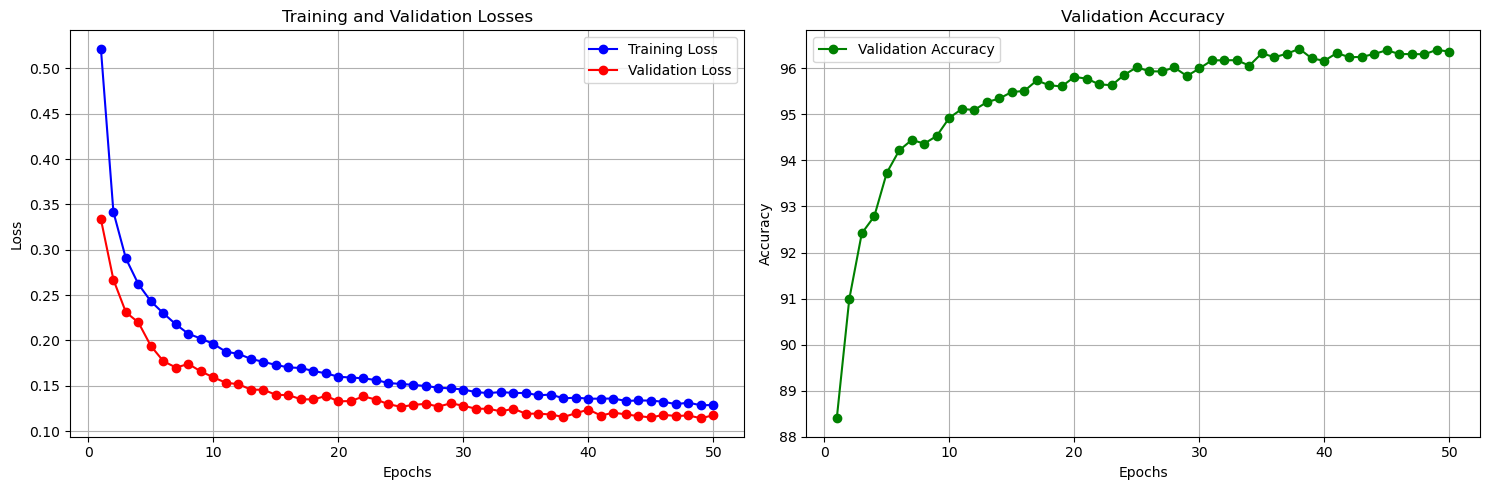

In [29]:
plot_metrics(num_epochs,
             train_losses,
             val_losses,
             val_accuracies,
             save_path=project_path+'/code/s4/models/s4-d64.png')

In [30]:
model.to('cpu')
cpu_usage, inference_time, _ = measure_cpu_utilization_and_run(compute_metrics_base, model, test_loader, model_path)

print(f'CPU usage during inference: {cpu_usage:.2f}%')
print(f'Inference time: {inference_time:.4f} seconds')

Size of the model: 275.92 KB
Accuracy on the test set: 96.36 %
CPU usage during inference: 0.30%
Inference time: 5.2648 seconds


## Even larger model (256 model dimensions)

In [22]:
model = S4Model(
    d_input=3, # num of feature
    d_output=6, # 6 classes
    d_model=256, # larger model dimension
    n_layers=4,
    dropout=0.2,
    lr=0.001,
    dropout_fn=nn.Dropout,
    prenorm=False,
)
model.to(device)
model.eval()

S4Model(
  (encoder): Linear(in_features=3, out_features=256, bias=True)
  (s4_layers): ModuleList(
    (0-3): 4 x S4D(
      (kernel): S4DKernel()
      (activation): GELU(approximate='none')
      (dropout): DropoutNd()
      (output_linear): Sequential(
        (0): Conv1d(256, 512, kernel_size=(1,), stride=(1,))
        (1): GLU(dim=-2)
      )
    )
  )
  (norms): ModuleList(
    (0-3): 4 x LayerNorm((256,), eps=1e-05, elementwise_affine=True)
  )
  (dropouts): ModuleList(
    (0-3): 4 x Dropout(p=0.2, inplace=False)
  )
  (decoder): Linear(in_features=256, out_features=6, bias=True)
)

In [24]:
import torch
from torch.nn import CrossEntropyLoss

# Define the optimizer and loss function
optimizer = torch.optim.Adam(model.parameters())

loss_fn = CrossEntropyLoss()

num_epochs = 50
best_val_accuracy = 0.0  # Variable to track the best validation accuracy
best_model_state = None  # Variable to store the state of the best model

train_losses = []  # List to store training losses
val_losses = []    # List to store validation losses
val_accuracies = []  # List to store validation accuracies

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for X_batch, y_batch in train_loader:
        inputs, labels = X_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        output = model(inputs)
        loss = loss_fn(output, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    avg_loss = running_loss / len(train_loader)
    train_losses.append(avg_loss)

    # Validation loss calculation
    val_loss, val_acc = validate(model, test_loader, device)
    val_accuracies.append(val_acc)
    val_losses.append(val_loss)

    # Save the model if the current validation accuracy is better than the best
    if val_acc > best_val_accuracy:
        best_val_accuracy = val_acc
        best_model_state = model.state_dict()

    print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {avg_loss:.4f}, Val Accuracy: {val_acc:.2f}%")

print('Finished Training')
model.load_state_dict(best_model_state)
print('Best model state restored')

# Save the best model
model_path = project_path+'/code/s4/models/s4-d64.pt'
torch.save(model.state_dict(), model_path)
print(f'Best model saved at {model_path}')

Epoch [1/50], Train Loss: 0.3039, Val Accuracy: 92.82%
Epoch [2/50], Train Loss: 0.2030, Val Accuracy: 94.54%
Epoch [3/50], Train Loss: 0.1694, Val Accuracy: 95.54%
Epoch [4/50], Train Loss: 0.1485, Val Accuracy: 95.69%
Epoch [5/50], Train Loss: 0.1338, Val Accuracy: 96.12%
Epoch [6/50], Train Loss: 0.1236, Val Accuracy: 96.16%
Epoch [7/50], Train Loss: 0.1141, Val Accuracy: 96.49%
Epoch [8/50], Train Loss: 0.1085, Val Accuracy: 96.54%
Epoch [9/50], Train Loss: 0.1025, Val Accuracy: 96.52%
Epoch [10/50], Train Loss: 0.0968, Val Accuracy: 96.67%
Epoch [11/50], Train Loss: 0.0912, Val Accuracy: 96.50%
Epoch [12/50], Train Loss: 0.0874, Val Accuracy: 96.78%
Epoch [13/50], Train Loss: 0.0858, Val Accuracy: 96.89%
Epoch [14/50], Train Loss: 0.0829, Val Accuracy: 96.94%
Epoch [15/50], Train Loss: 0.0790, Val Accuracy: 97.03%
Epoch [16/50], Train Loss: 0.0782, Val Accuracy: 96.97%
Epoch [17/50], Train Loss: 0.0743, Val Accuracy: 96.76%
Epoch [18/50], Train Loss: 0.0734, Val Accuracy: 97.03%
E

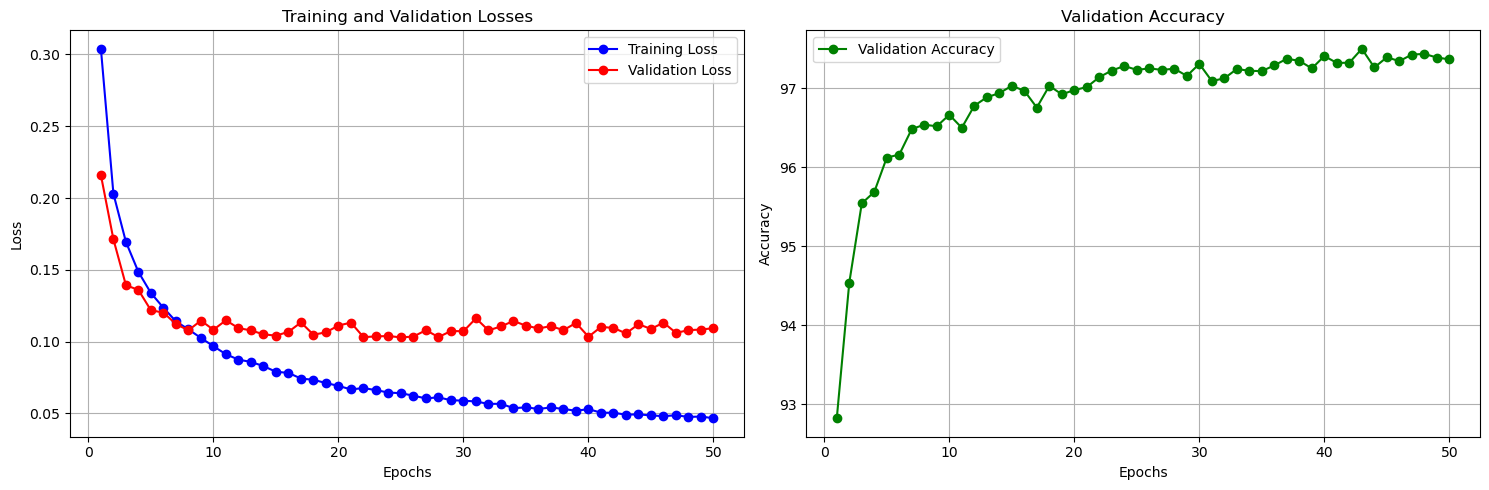

In [26]:
plot_metrics(num_epochs,
             train_losses,
             val_losses,
             val_accuracies,
             save_path=project_path+'/code/s4/models/s4-d256.png')

In [25]:
model.to('cpu')
cpu_usage, inference_time, _ = measure_cpu_utilization_and_run(compute_metrics_base, model, test_loader, model_path)

print(f'CPU usage during inference: {cpu_usage:.2f}%')
print(f'Inference time: {inference_time:.4f} seconds')

Size of the model: 2605.55 KB
Accuracy on the test set: 97.37 %
CPU usage during inference: 0.60%
Inference time: 8.7462 seconds
